# Image Reconstruction using Compressed Sensing

Here we will look at an example of image reconstruction using compressed sensing and the discrete cosine transform (DCT).

Natural images are effectively sparse in the DCT domain.
Using this information, we can attempt to reconstruct natural images that have been randomly sampled at fairly low rates.

Python is not the best language to do heavy computation natively, but we can effectively show some examples at low resolutions.

First, we will import the necessary libraries:

In [6]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx

Next, we will define a few functions to more easily compute 2-dimensional DCTS in Python.

This is a common function, but scikit does not have multidimensional DCTs implemented explicitly, so these functions allow our code to be more readable:

In [7]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

Now, we will read in our image.
As mentioned previously, Python is a little slow for our computations, so we convert the image to greyscale and downsample it to reduce the resolution. Then the image is displayed.

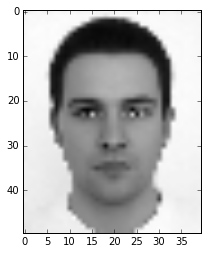

In [9]:
Iorig = spimg.imread('face.jpg', flatten=True, mode='L')
I = spimg.zoom(Iorig, 0.125)
plt.imshow(I, cmap = 'gray')
plt.show()

Now, we will randomly sample 50% of the image and display it. These pixels and the fact that the original image is sparse in the DCT domain are what we will use to attempt reconstruction.

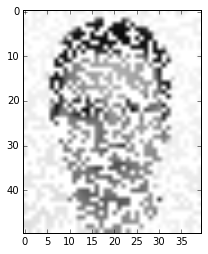

In [15]:
ny, nx = I.shape

samples = round(nx * ny * 0.50) 
randi = np.random.choice(nx * ny, samples, replace=False)
b = I.T.flat[randi]
b = np.expand_dims(b, axis=1)

mask = np.zeros(I.shape)
mask.T.flat[randi] = 255
Isampled = 255 * np.ones(I.shape)
Isampled.T.flat[randi] = I.T.flat[randi]
plt.imshow(Isampled, cmap = 'gray')
plt.show()

Here we use the Kroneker function from NumPy to create a DCT matrix for the image.
By only taking those rows corresponding to the pixels that were sampled, we have our A matrix, which should be Phi \* Psi

In [16]:
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[randi,:]

Next we peform our L-1 optimization.
This optimization is looking for the solution to Ax=b with the smallest L-1 norm for x.

Intuitively, this is looking for a possible signal in the DCT domain which, when transformed back to the original domain, would yield our sampled pixel values. Since we know the signal should be sparse in the DCT domain, we are minimizing the L-1 norm in that domain.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  +9.576e-21  +7e+06  1e+00  1e-02  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  +9.183e+03  +9.337e+03  +3e+06  9e-01  5e-03  2e+02  8e+02  0.6530  1e-01   1  0  1 |  0  0
 2  +1.383e+04  +1.388e+04  +8e+05  6e-01  1e-03  5e+01  2e+02  0.7714  3e-02   1  0  1 |  0  0
 3  +2.290e+04  +2.292e+04  +2e+05  2e-01  3e-04  2e+01  5e+01  0.7666  2e-02   1  0  0 |  0  0
 4  +3.311e+04  +3.311e+04  +6e+04  7e-02  9e-05  6e+00  2e+01  0.7173  3e-02   1  1  1 |  0  0
 5  +4.049e+04  +4.049e+04  +2e+04  2e-02  3e-05  2e+00  5e+00  0.7054  5e-02   1  1  1 |  0  0
 6  +4.363e+04  +4.363e+04  +7e+03  8e-03  1e-05  9e-01  2e+00  0.6996  7e-02   1  1  1 |  0  0
 7  +4.466e+04  +4.466e+04  +3e+03  3e-03  4e-06  4e-01  7e-01  0.6688  7e-02   1  1  1 |  0  0
 8  +4.504e+04  +4.504e+04  +1e+03  1e-03  1e-

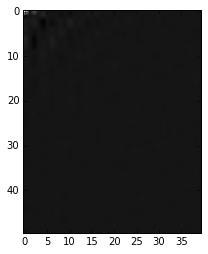

In [18]:
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Iat2 = np.array(vx.value).squeeze()

Iat = Iat2.reshape(nx, ny).T

plt.imshow(Iat, cmap = 'gray')
plt.show()

As you can see, the x value we obtained visualizes as mostly black, meaning most of its values are 0 or very close to 0.

Now, we peform an inverse DCT on these coefficients to attempt to recover our our original image:

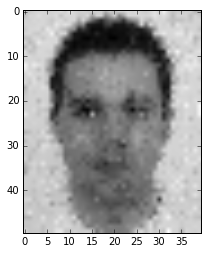

In [20]:
Ia = idct2(Xat)
plt.imshow(Ia, cmap = 'gray')
plt.show()

This results in what we consider to be recognizable as a face, but not immediately impressive.

Our main reason for this is the downsampling that we started with.
We know that natural images are sparse in the DCT domain, but since we were trying to save computation time, we heavily downsampled our image.
As a result, the image we operated on was much less sparse in the DCT domain.
Thus, our implicit assumption of sparsity was less solid than if we had used the original image.

We do have some results that we computed offline for a higher-resolution version of the same image, in which you can see better results.